# Sub Basin Delineation

We want the catchment unique to each reach (unnested). 
Once we have the catchments we can work on extracting the valley bottom.

Both WhiteBoxTools (using subbasins) and GrassGIS (using r.watershed) can do this on a river network.

Using NHD stream flowlines presents two challenges:
1) How to handle when the flowline doesn't line up with the terrain
2) How to handle creating pour points unique to each segment. Where two segments meet, they share a coordinate.

For option 1) could try using the snap pour points tool on every single coordinate in the line segments. Then rasterize the line segments. Then continue with the workflow.

For 2) I think the easiest is to delineate the catchments at the segment level, and only then do further splitting by assigning pour points at specified locations on the segment to delineate a reach (e.g every 1000m).

Thus the workflow:
- Create a stream network raster (either by thresholding flow accumulation, or from NHD vectors)
- Run subbasins tool with input stream raster and d8 pointer
- Further split the subbasins using pour points

Alternatively, can start with the NHDPlus HUC12 Catchment boundaries. 

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray 
import os
import shutil
import tempfile
import whitebox
import shapely

In [106]:
# load toy data
dem = rioxarray.open_rasterio('../toy_data/dem_3m.tif')

## WhiteBoxTools

Workflow option 1:
 - Flow Accumulation (fill depressions, flow direction, flow accumulation)
 - Extract Streams (threshold flow accumulation)
 - SubBasins (input streams and flow direction)

In order to have reaches and not just stream network segments need option 2:
- Flow Accumulation
- Extract Streams
- Split Segments
- Get pour points (end of segment)
- Snap to flow accumulation (if using NHD)
- Watershed tool
- UnnestBasins (maybe not necessary)

In [107]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir(os.path.expanduser("~/opt/WBT/"))

working_directory = os.path.abspath("../data/whitebox_outputs/")
if os.path.exists(working_directory):
    shutil.rmtree(working_directory)
os.mkdir(working_directory)
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

### Extract SubBasins

In [108]:
# get flow direction and flow accumulation
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/tmpfpy1thby.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 876
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.9s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif'

In [109]:
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)
d8_pntr_file

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.14s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif'

In [110]:
params = {
    "i": d8_pntr_file,
    "output": os.path.join(working_directory, "d8_flow_acc.tif"),
    "out_type": "cells",
    "log": False,
    "clip": False,
    "pntr": True,
    "esri_pntr": False,
    "callback": my_callback
}
flow_acc = wb_wrapper(wbt.d8_flow_accumulation, params, return_file=False)

./whitebox_tools --run="D8FlowAccumulation" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --input='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_flow_acc.tif' --out_type=cells --pntr -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.37s


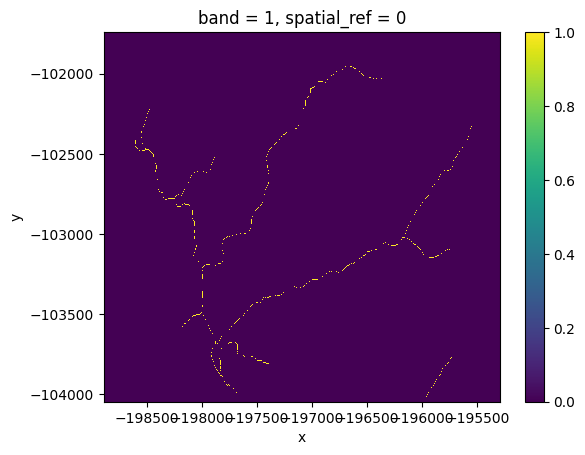

In [111]:
# decide on a threshold for flow accumulation
threshold = 20000
(flow_acc > threshold).plot()

In [179]:
params = {
    "flow_accum": flow_acc,
    "output": os.path.join(working_directory, "streams.tif"),
    "threshold": threshold,
    "zero_background": False,
    "callback": my_callback
}
streams_file = wb_wrapper(wbt.extract_streams, params, return_file=True)

./whitebox_tools --run="ExtractStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --flow_accum='/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/tmpx602o789.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --threshold='20000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.6s


In [209]:
params = {
    'd8_pntr': d8_pntr_file, 
    'streams': streams_file, 
    'output': os.path.join(working_directory, "subbasins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)

./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/subbasins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.42s


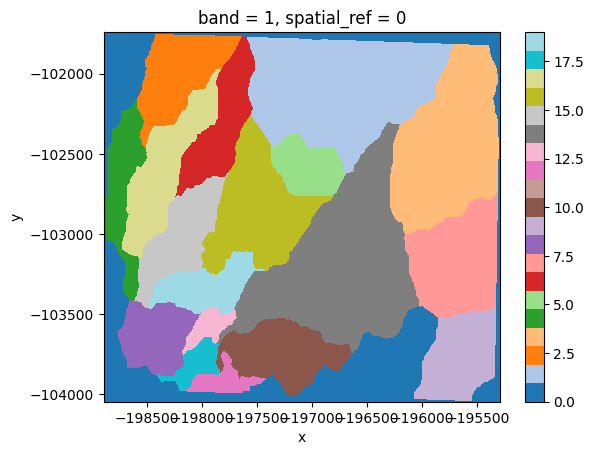

In [117]:
basins.data[basins.data == -32768] = 0
basins.plot(cmap='tab20')

## Split into Reaches

Want to create polygon boundaries for each subbasin
- either use geocube https://github.com/corteva/geocube/blob/master/docs/examples/vectorize.ipynb
- or https://rasterio.readthedocs.io/en/latest/topics/features.html
    
Given one subbasin polygon, clip the dem and the flowlines vectors
split the flowline (should only be one in the polygon) into equal length segments to get the pour points
run watershed


In [190]:
params = {
    'streams': streams_file, 
    'd8_pntr': d8_pntr_file, 
    'output': os.path.join(working_directory, "streams.shp"), 
    'esri_pntr': False, 
    'callback': my_callback
}
streams_shp_file = wb_wrapper(wbt.raster_streams_to_vector, params, return_file=True)

./whitebox_tools --run="RasterStreamsToVector" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --streams='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.shp' -v --compress_rasters=False

************************************
* Welcome to RasterStreamsToVector *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Reading pointer data...
Reading streams data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s


In [253]:
import pprint
import rasterio
from rasterio import features

basins.rio.to_raster('../data/whitebox_outputs/subbasins.tif', driver="GTiff")
with rasterio.open(os.path.join(working_directory, 'subbasins.tif')) as src:
    b = src.read(1)

mask = b != -32768
shapes = features.shapes(b, mask=mask, transform=src.transform)

records = []
for shape,id in shapes:
    coords = shape['coordinates'][0]
    poly = shapely.Polygon(coords)
    records.append({'id': id, 'geometry': poly})
basin_polygons = gpd.GeoDataFrame.from_records(records)

In [254]:
basin_polygons.head(4)

,id,geometry
0,17.0,"POLYGON ((-197817.819 -101962.722, -197817.819..."
1,2.0,"POLYGON ((-198420.269 -101749.916, -198393.293..."
2,15.0,"POLYGON ((-197751.879 -102601.139, -197751.879..."
3,15.0,"POLYGON ((-197754.876 -102604.136, -197754.876..."


<Axes: >

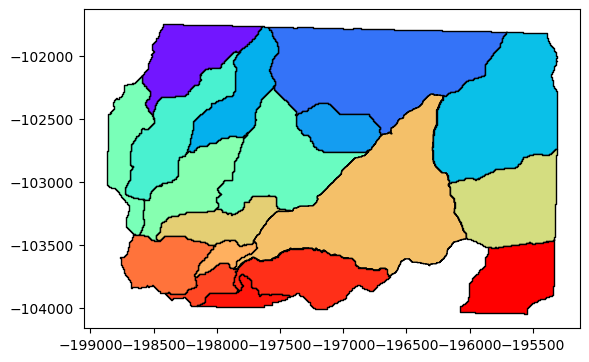

In [245]:
basin_polygons.plot(cmap='rainbow', edgecolor='black')

In [250]:
test_basin_id = 12

In [251]:
basin_polygons[basin_polygons['id'] == test_basin_id]

,id,geometry
26,12.0,"POLYGON ((-197835.802 -103848.000, -197835.802..."
27,12.0,"POLYGON ((-197838.800 -103850.997, -197838.800..."
32,12.0,"POLYGON ((-197808.827 -103731.106, -197790.844..."


In [255]:
ids = basin_polygons.dissolve(by='id')
ids

,geometry
id,
0.0,"POLYGON ((-198893.836 -101740.925, -198893.836..."
1.0,"MULTIPOLYGON (((-196612.920 -102619.122, -1966..."
2.0,"POLYGON ((-198420.269 -101749.916, -198393.293..."
3.0,"MULTIPOLYGON (((-196169.325 -103020.755, -1961..."
4.0,"POLYGON ((-198594.110 -102157.544, -198591.112..."
5.0,"POLYGON ((-197182.399 -102373.347, -197170.410..."
6.0,"POLYGON ((-197640.980 -101767.900, -197625.994..."
7.0,"POLYGON ((-195315.105 -102736.016, -195312.108..."
8.0,"MULTIPOLYGON (((-198645.063 -103416.394, -1986..."


In [263]:
ids.explode()

/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/ipykernel_96486/3582818835.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ids.explode()


geometry
id                                                       
0.0  0  POLYGON ((-198893.836 -101740.925, -198893.836...
1.0  0  POLYGON ((-196612.920 -102619.122, -196612.920...
     1  POLYGON ((-197497.112 -101770.897, -197497.112...
2.0  0  POLYGON ((-198420.269 -101749.916, -198393.293...
3.0  0  POLYGON ((-196169.325 -103020.755, -196169.325...
     1  POLYGON ((-196163.330 -103014.761, -196163.330...
     2  POLYGON ((-196163.330 -103014.761, -196163.330...
     3  POLYGON ((-195704.749 -101815.856, -195578.864...
4.0  0  POLYGON ((-198594.110 -102157.544, -198591.112...
5.0  0  POLYGON ((-197182.399 -102373.347, -197170.410...
6.0  0  POLYGON ((-197640.980 -101767.900, -197625.994...
7.0  0  POLYGON ((-195315.105 -102736.016, -195312.108...
8.0  0  POLYGON ((-198645.063 -103416.394, -198600.104...
     1  POLYGON ((-198015.638 -103497.320, -198015.638...
     2  POLYGON ((-198015.638 -103497.320, -198015.638...
     3  POLYGON ((-198012.641 -103491.325, -198009.644...
     4  POLYGON ((-198006.646 -103491.325, -198009.644...
9.0  0  POLYGON ((-195333.089 -103452.361, -195330.092...
10.0 0  POLYGON ((-197835.802 -103868.980, -197838.800...
     1  POLYGON ((-197275.315 -103521.298, -197275.315...
12.0 0  POLYGON ((-197790.844 -103731.106, -197790.844...
     1  POLYGON ((-197838.800 -103865.983, -197838.800...
     2  POLYGON ((-197832.805 -103848.000, -197832.805...
13.0 0  POLYGON ((-197706.920 -103455.358, -197703.923...
14.0 0  POLYGON ((-196310.196 -102304.410, -196289.215...
15.0 0  POLYGON ((-197757.874 -102625.117, -197760.871...
     1  POLYGON ((-197754.876 -102607.133, -197754.876...
     2  POLYGON ((-197754.876 -102607.133, -197754.876...
     3  POLYGON ((-197748.882 -102601.139, -197748.882...
16.0 0  POLYGON ((-197548.065 -102232.476, -197545.068...
17.0 0  POLYGON ((-197850.789 -101965.719, -197850.789...
     1  POLYGON ((-197817.819 -101962.722, -197814.822...
18.0 0  POLYGON ((-197979.671 -103644.186, -197910.734...
19.0 0  POLYGON ((-197587.030 -103104.679, -197587.030...
     1  POLYGON ((-198000.652 -103206.586, -197997.655...